In [99]:
import pandas as pd
import numpy as np
from glob import glob
import warnings
import matplotlib.pyplot as plt
import rasterio as rio
import xarray as xr
import rioxarray as rxr

warnings.simplefilter('ignore', FutureWarning)

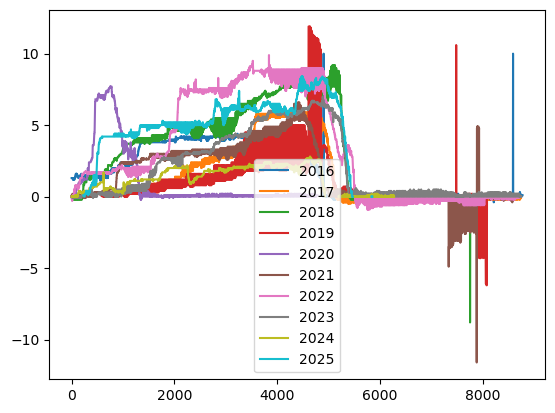

In [89]:
files = sorted(glob('/Users/ropa5718/Downloads/947*'))
df = pd.read_csv(files[0], header=1, parse_dates=[[1,2]], na_values=[-99.9])
df.index = df['Date_Time']
df.drop(columns=['Date_Time', 'Site Id'], inplace=True)

for f in files[1:]:
    df_tmp = pd.read_csv(f, header=1, parse_dates=[[1,2]], na_values=[-99.9])
    df_tmp.index = df_tmp.Date_Time
    df_tmp.drop(columns=['Date_Time', 'Site Id'], inplace=True)
    df = pd.concat([df, df_tmp])

df[df==-99] = np.nan
df['WaterYear'] = [i.year + 1 if i.month in [10,11,12] else i.year for i in df.index]
df = df.loc[df['WaterYear']>=2016]

fig, ax = plt.subplots()
for year in df['WaterYear'].unique():
    data = df.loc[df['WaterYear']==year,'WTEQ.I-1 (in) '].reset_index()
    data.loc[data['WTEQ.I-1 (in) ']==-99.9, 'WTEQ.I-1 (in) '] = np.nan
    data['WTEQ.I-1 (in) '].plot(ax=ax, label=year)
ax.legend() 
    


In [57]:
(df.groupby('WaterYear').max()['WTEQ.I-1 (in) '] * .0254).sort_values()

WaterYear
2024    0.07112
2017    0.15494
2021    0.16764
2023    0.17780
2020    0.19558
2025    0.21336
2018    0.23368
2022    0.25146
2016    0.25400
2019    0.30226
Name: WTEQ.I-1 (in) , dtype: float64

<Axes: xlabel='Date_Time'>

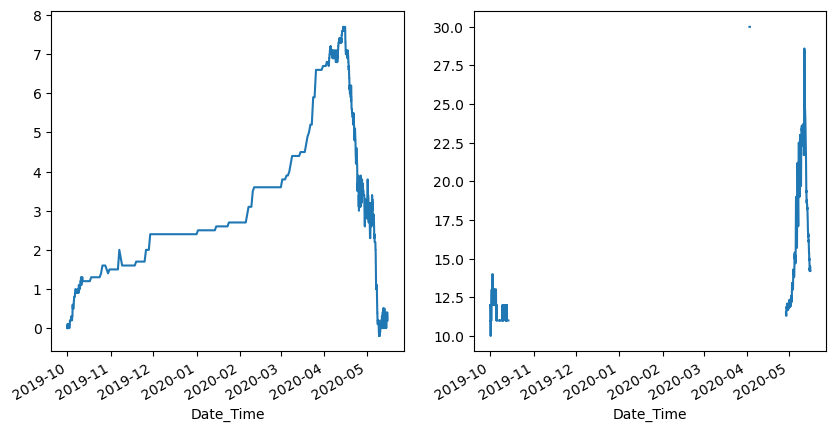

In [98]:
df.loc[df['WTEQ.I-1 (in) ']==-99.9, 'WTEQ.I-1 (in) '] = np.nan
timeseries = slice('2019-10-01','2020-05-15')
fig, ax = plt.subplots(1, 2, figsize=(10,5))
df.loc[timeseries, 'WTEQ.I-1 (in) '].plot(ax=ax[0])
df.loc[timeseries, 'SMS.I-1:-2 (pct) '].plot(ax=ax[1])

## Soil functions

In [160]:
Lambda = 0.2385
main_inc_angle = 40

def real_part_1_4GHz(S, C, mv, a0 = 2.862, a1 = -0.012, a2 = 0.001, b0 = 3.803, b1 = 0.462, b2 = -0.341, c0 = 119.006, c1 = -0.500, c2 = 0.633):
    """
    Imaginary polynomial of Hallikainen et al. (1985)'s Table II (row 1)

    Parameters are from row 1 of table II of Hallikainen et al. (1985) at 1.4 GHz
    and Equation 14 of of Hallikainen et al. (1985)
    DOI: 10.1109/TGRS.1985.289497

    Gives real component of permittivity based on volumetric moisture (mv), sand content (S), and clay content (C).
    S and C are dry soil percentage by weight with remaining fraction assumed to consist of silt. 
    """
    
    # Parameters are from row 1 of table II of Hallikainen et al. (1985) at 1.4 GHz
    # and Equation 14 of of Hallikainen et al. (1985)
    e_real = (a0 + a1*S + a2*C) + (b0 + b1*S + b2*C) * mv + (c0 + c1*S + c2*C) * mv**2
    return e_real

def imaginary_part_1_4GHz(S, C, mv, a0 = 0.356, a1 = -0.003, a2 = -0.008, b0 = 5.507, b1 = 0.044, b2 = -0.002, c0 = 17.753, c1 = -0.313, c2 = 0.206):
    """
    Imaginary polynomial of Hallikainen et al. (1985)'s Table II (row 11)

    Parameters are from row 1 of table II of Hallikainen et al. (1985) at 1.4 GHz
    and Equation 14 of of Hallikainen et al. (1985)
    DOI: 10.1109/TGRS.1985.289497

    Gives imaginary component of permittivity based on volumetric moisture (mv), sand content (S), and clay content (C).
    S and C are dry soil percentage by weight with remaining fraction assumed to consist of silt. 
    """
    e_imaj = (a0 + a1*S + a2*C) + (b0 + b1*S + b2*C) * mv + (c0 + c1*S + c2*C) * mv**2
    return e_imaj

def complex_e_1_4GHz(mv, S, C):
    """
    Combines real and imaginary permittivities calculated by table II in Hallikainen et al. (1985)
    DOI: 10.1109/TGRS.1985.289497

    Gives complex permittivity based on volumetric water content (mv), sand content (S), and clay content (C).
    S and C are dry soil percentage by weight with remaining fraction assumed to consist of silt. 
    """
    # subtract imaginary part to get realistic values
    return real_part_1_4GHz(S, C, mv) - 1j * imaginary_part_1_4GHz(S, C, mv)

def soil_vertical_wave_number_from_permittivity(e_prime, wavelength = Lambda, magnetic_permeability = 1.0, incidence_angle = np.deg2rad(main_inc_angle)): # RTP: Zach did not convert to rad here
    """
    Equation 5 from De Zan et al. (2014)
    Digital Object Identifier 10.1109/TGRS.2013.2241069

    Gives the soil perpendicular (z) wavenumber given a soils dielectric permittivity.
    """
    c = 3e8
    f = c / wavelength
    w = 2 * np.pi * f

    kx = (2 * np.pi / wavelength) * np.sin(incidence_angle)

    kz = np.sqrt(w**2 * e_prime * magnetic_permeability - kx**2)
    return kz

def phase_soil_wave_number(e1_prime, e2_prime, magnetic_permeability = 1.0):
    """
    Equation 12 from De Zan et al. (2014)
    Digital Object Identifier 10.1109/TGRS.2013.2241069

    Gives the phase change based on two soil dielectric permittivities
    """
    kz1= soil_vertical_wave_number_from_permittivity(e1_prime)
    kz2 = soil_vertical_wave_number_from_permittivity(e2_prime)
    return 1/(2*1j * kz1 - 2* 1j * np.conj(kz2))


# # setup soils matching those in Hallikainen et al. (1985)
# soils = [{"sand": 51.5, "clay": 13.5}, {"sand": 42, "clay": 8.5}, {"sand": 30.6, "clay": 13.5}, {"sand": 17.2, "clay": 19.0}, {"sand": 5.0, "clay" : 47.4}]
# for soil in soils:
#     sand = soil['sand']
#     clay = soil['clay']
#     for j, smv in enumerate(sec_mv):
#         phase[j] = np.angle(phase_soil_wave_number(e1_prime = complex_e_1_4GHz(S = sand, C = clay, mv = rmv), e2_prime=complex_e_1_4GHz(S = sand, C = clay, mv = smv)))
#     ax.plot(sec_mv, swe_from_phase(phase)*100, label = f'Sand: {sand}%, Clay: {clay}%, Silt: {100 - (clay + sand)}%')


def vectorize_soils(sand, clay, sm):
    return np.angle(phase_soil_wave_number(e1_prime = complex_e_1_4GHz(S = sand, C = clay, mv = sm), e2_prime=complex_e_1_4GHz(S = sand, C = clay, mv = sm)))


/var/folders/qw/0hrz2r9d1hgffvdv588xr_9r0000gp/T/ipykernel_34616/3992834926.py:71: RuntimeWarning: invalid value encountered in scalar divide
  return 1/(2*1j * kz1 - 2* 1j * np.conj(kz2))


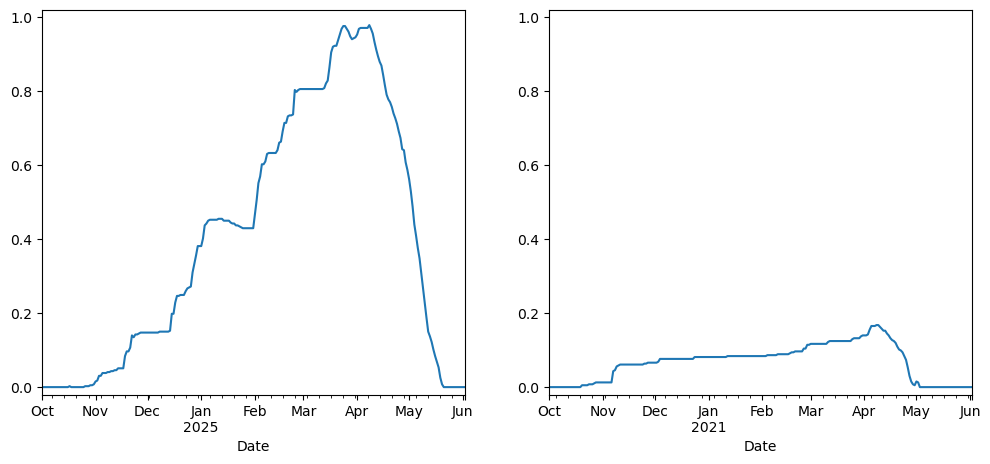

In [163]:
mores = pd.read_csv('../data_sandbox/swe_errors/637_ALL_WATERYEAR=2025.csv', header=1, 
                    index_col='Date', parse_dates=[1], na_values=[-99.9]).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct)  (silt)':'sm_2cm'})
mores.drop(columns=['Site Id','Time'], inplace=True)
mores['swe'] *= 0.0254

chena = pd.read_csv('../data_sandbox/swe_errors/947_ALL_WATERYEAR=2021.csv', header=1, 
                    index_col='Date', parse_dates=[1], na_values=[-99.9]).rename(columns={'WTEQ.I-1 (in) ':'swe','SMS.I-1:-2 (pct) ':'sm_2cm'})
chena.drop(columns=['Site Id','Time'], inplace=True)
chena['swe'] *= 0.0254
chena = chena.loc[:'2021-06-02']

mores_12day = mores.diff(periods=12)['sm_2cm']/100
chena_12day = chena.diff(periods=12)['sm_2cm']/100


mores_soil_phase = [vectorize_soils(sand=45.1, clay=14.4, sm=sm) for sm in mores_12day]

# np.angle(phase_soil_wave_number(e1_prime = complex_e_1_4GHz(S=45.1, C=14.4, mv=rmv), e2_prime=complex_e_1_4GHz(S = sand, C = clay, mv = smv)))


fig, ax = plt.subplots(1, 2, figsize=(12,5))
mores['swe'].plot(ax=ax[0], label='SNOTEL')

chena['swe'].plot(ax=ax[1], label='SNOTEL')

for axx in ax.flatten():
    axx.set_ylim([-0.02, 1.02])

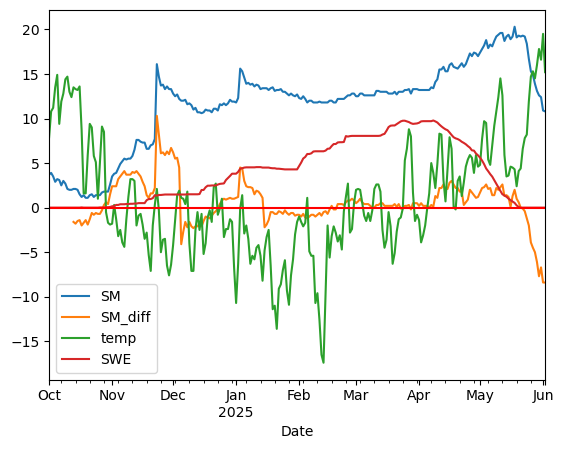

In [142]:
mores['sm_2cm'].plot(label='SM')
mores_12day.plot(label='SM_diff')
mores['TAVG.D-1 (degC) '].plot(label='temp')
(mores['swe']*10).plot(label='SWE')
plt.axhline(0, color='red')
plt.legend()

In [166]:
[sm for sm in mores_12day]

[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 -0.016,
 -0.018,
 -0.015,
 -0.013999999999999999,
 -0.02,
 -0.017,
 -0.013999999999999999,
 -0.019,
 -0.013000000000000003,
 -0.006000000000000001,
 -0.008,
 -0.006000000000000001,
 -0.007000000000000002,
 -0.007000000000000002,
 -0.0030000000000000005,
 0.0030000000000000005,
 0.006000000000000001,
 0.004000000000000001,
 0.015,
 0.024,
 0.024,
 0.024,
 0.032,
 0.035,
 0.038000000000000006,
 0.040999999999999995,
 0.037000000000000005,
 0.037000000000000005,
 0.037000000000000005,
 0.04,
 0.039,
 0.040999999999999995,
 0.038,
 0.035,
 0.028999999999999995,
 0.023999999999999994,
 0.013999999999999995,
 0.010999999999999996,
 0.015999999999999997,
 0.015999999999999997,
 0.022000000000000002,
 0.10300000000000001,
 0.08199999999999999,
 0.061,
 0.06200000000000001,
 0.059000000000000004,
 0.063,
 0.06000000000000001,
 0.067,
 0.06200000000000001,
 0.055,
 0.055999999999999994,
 0.04499999999999999,
 -0.04100000000